# Сентимент-анализ отзывов на мобильные телефоны

## Постановка задачи
Дано сто отзывов на мобильные телефоны, разделённых на два класса по своей эмоциональной окраске: положительные и отрицательные. Задачей является построение модели машинного обучения, предсказывающей, к какому классу относится отзыв. При этом исходная выборка используется для проверки качества обученной модели. В качестве метрики используется точность (accuracy), что является обоснованным, так как классы в тестовой выборке сбалансированы. Желаемым является значение метрики не менее 0.85.

## Сбор данных
Источником данных для обучения модели послужил раздел "Смартфоны" на Яндекс Маркете. Отзывов в разделе довольно много, и каждый имеет пользовательскую оценку от одной до пяти звёзд. Последнее позволяет автоматически разделить отзывы на положительные и отрицательные. Проблема в том, что Яндекс Маркет активно мешает использованию ботов, а доступ к API предоставляет только платно, поэтому было решено использовать веб-скрэйпер, написанный с помощью python-интерфейса Selenium - инструмента для автоматизации действий веб-браузера. Такой скрэйпер детектируется не сразу, и, в худшем случае, за время его работы несколько раз придётся вручную решить капчу. "Обычные" же скрейперы, вроде Scrapy, с Яндекс Маркетом не работают вообще, так как на их запросы сервер отвечает, что доступ запрещён (403).

Отзывы на Яндекс Маркете имеют следующую структуру: текст разделён на описание достоинств, описание недостатков и пользовательский комментарий. При этом можно встретить как отзывы, следующие этому разделению, так и, например, такие, основное содержание которых находится в комментарии. Поэтому было решено сохранять тексты из всех трёх разделов (некоторые из них могут в отзыве отсутствовать), а затем объединять их в один, разделив переносом строки. Названия разделов не сохраняются.

Скрипт, использованный для сбора данных, может быть найден в папке ym_scraping, вместе с результатом его работы - файлом data_ym_raw.txt. Для того, чтобы скрипт заработал, необходимо загрузить веб драйвер для соответствующего браузера, а затем указать внутри файла скрипта путь к нему. В данном проекте был использован Chrome Webdriver, скачать который можно по ссылке https://sites.google.com/a/chromium.org/chromedriver/downloads. Стоит заметить, что скрипт на момент написания работал нестабильно, а, учитывая тенденцию веб-сайтов меняться со временем, вообще, скорее всего, через некоторое время вообще перестанет работать. Поэтому запускать его вряд ли имеет смысл.

## Импорт библиотек
Теперь, когда данные для обучения собраны, импортируем всё необходимое для выполнения проекта. Предварительная обработка данных будет производиться с помощью библиотек pandas (удаление дубликатов, слишком коротких отзывов и пропущенных значений, а также разметка отзывов на основе оценок покупателей) и spacy (лемматизация текстов отзывов). Для построения и оценки моделей будет использована библиотека scikit-learn.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from numpy import vectorize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer, FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score

## Предварительная обработка данных
### Загрузка данных
Загрузим собранные данные с помощью метода read_csv из библиотеки pandas и посмотрим на них.

In [3]:
data_ym_raw = pd.read_csv('data_ym_raw.tsv', sep='\t', names=['text', 'rating'])
data_ym_raw

,text,rating
0,Долго держит заряд. Яркий и четкий экран. Есть...,5
1,"Камера, шустрый, цвет красивый, памяти много Н...",5
2,"Удобный, громкий, хорошо сидит в руке.",5
3,"неплохие камеры, шустрость начинки, удобный ра...",4
4,"После включения обновляем прошивку, далее с по...",5
...,...,...
141691,Цена Пока что нет -,4
141692,Для смартфона столь доступного по цене достоин...,5
141693,Камера Внешний вид Эргономика Плавность и быст...,5
141694,"Неплохая автономность, 10,5 часов работы экран...",4


### Удаление дубликатов
Как можно видеть, отзывов получилось даже слишком много. Дело в том, что в данных присутствует множество дубликатов, связанных с неоптимальностью работы скрипта по их сбору: отзывы с текущей страницы он сохранял по нескольку раз, пока грузилась следующая. Посмотрим, насколько много дубликатов в данных.

In [4]:
print(f'Всего отзывов: {data_ym_raw.shape[0]:>16}')
print(f'Всего уникальных отзывов: {data_ym_raw.text.unique().shape[0]}')

Всего отзывов:           141696
Всего уникальных отзывов: 23229


Видно, что уникальные отзывы составляют лишь примерно седьмую часть от всех собранных. Начнём очистку данных: удалим все дубликаты.

In [5]:
# Операция не меняет исходный DataFrame, а возвращает результат, поэтому сохраним его в новую переменную.
data_ym_unique = data_ym_raw.drop_duplicates()

### Удаление пропущенных значений
Теперь посмотрим на количество пропущенных значений в данных. Их появление вызвано тем, что иногда отзывы не содержали ни одного из сохраняемых скриптом разделов.

In [6]:
print(f'Пропущенных значений в текстах отзывов: {data_ym_unique.text.isna().sum()}')
print(f'Пропущенных значений в пользовательских оценках: {data_ym_unique.rating.isna().sum()}')

Пропущенных значений в текстах отзывов: 5
Пропущенных значений в пользовательских оценках: 0


Пропущенных значений всего пять, и их смело можно удалить.

In [7]:
data_ym_unique_not_na = data_ym_unique.dropna()

### Удаление слишком коротких и слишком длинных отзывов
Теперь имеет смысл отфильтровать тексты отзывов по их длине. Понятно, что слишком короткие отзывы могут пагубно сказаться на качестве модели, так как содержат недостаточно информации, чтобы сделать правильное предсказание. Длинные же тексты отзывов, вероятнее всего, представляют собой обширные описания опыта использования товара, и для предсказания их эмоциональной окраски требуется понимание всего текста целиком, что не под силу модели. Всё это - предположения, основанные на здравом смысле, но стоит иметь в виду, что они необязательно верны.

Для начала посмотрим на гистограмму числа слов всех уникальных отзывов.

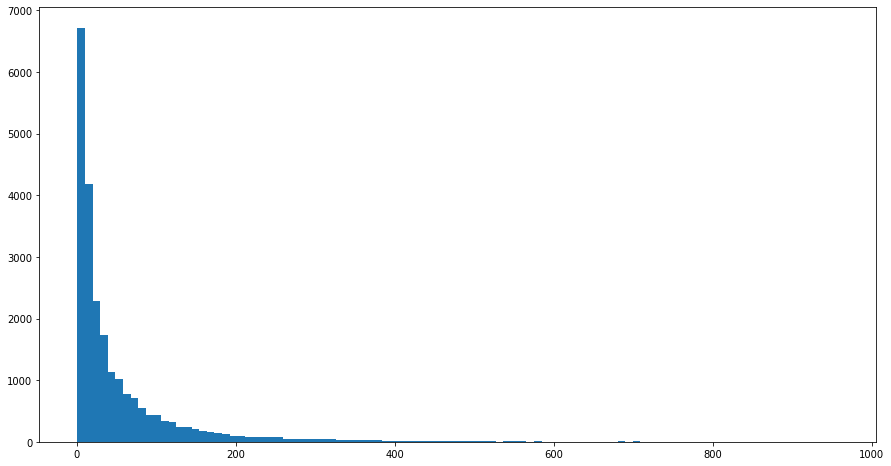

In [8]:
# Найдём число слов каждого уникального отзыва.
text_lengths = data_ym_unique_not_na.text.apply(lambda x: len(x.split(" ")))

# Для построения гистограммы воспользуемся модулем pyplot библиотеки matplotlib.
plt.figure(figsize=(15, 8))
plt.hist(text_lengths, bins=100)
plt.show()

Как видно, распределение числа слов в отзыве очень похоже на экспоненциальное, что интересно уже само по себе. Исходя из гистограммы, принято решение далее рассматривать только те отзывы, число слов в которых не превышает четырёхсот. Таких отзывов крайне мало, поэтому их удаление не должно негативно сказаться на качестве модели.

Чтобы понять, какие отзывы следует считать слишком короткими, рассмотрим гистограмму числа слов отзывов вблизи нуля.

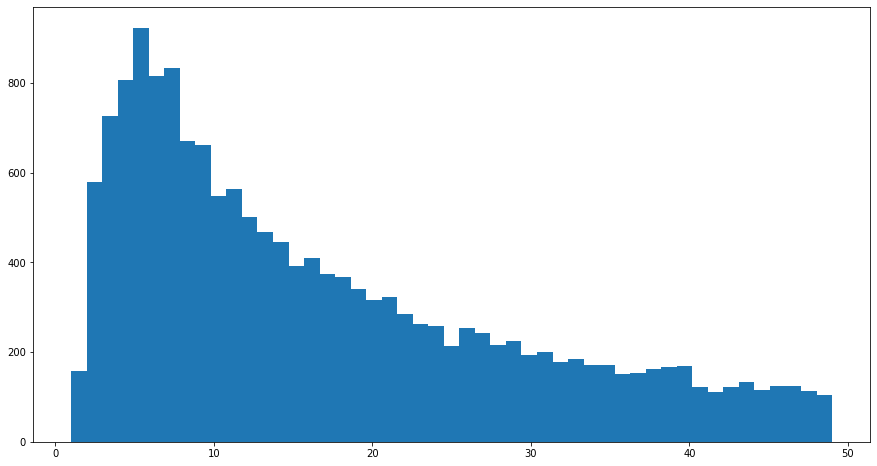

In [9]:
# Выделим только длины отзывов меньше пятидесяти слов.
text_lengths_short = text_lengths[text_lengths < 50]

# Параметр bins подбираем так, чтобы форма распределения была лучше всего видна.
plt.figure(figsize=(15, 8))
plt.hist(text_lengths_short, bins=49)
plt.show()

Как видно, вблизи нуля распределение сначала растёт, а потом начинает убывать. Возьмём в качестве нижней границы числа слов в отзыве пять - значение, после которого распределение убывает. Это догадка, которую можно объяснить тем, что это единственное явно выделенное значение распределения. На самом деле, конечно, такой параметр следовало бы подбирать, но в данном проекте этого сделано не будет.

Оставим только те отзывы, число слов в которых не менее пяти и не более четырёхсот.

In [10]:
# В условии используется оператор &, так как он векторизован. 
data_ym_clean = data_ym_unique_not_na[(text_lengths >= 5) & (text_lengths <= 400)]

На этом очистка данных завершена.

### Разделение отзывов на классы
Постановка задачи требует, чтобы модель предсказывала принадлежность отзыва к одному из двух классов, поэтому каждый отзыв следует отнести либо к положительным (метка 1), либо к отрицательным (метка 0), основываясь на пользовательских оценках.

Для начала посмотрим, как распределены значения колонки rating, содержащей пользовательские оценки.

In [11]:
print(data_ym_clean.rating.value_counts())

5    14768
4     3011
3     1342
1      956
2      694
Name: rating, dtype: int64


Сразу же можно заметить две проблемы. Первая сосотоит в том, что отзывов с низкими оценками (1 и 2) намного меньше, чем остальных. Эту проблему необходимо будет решить, так как в тестовой выборке классы сбалансированы. Вторая проблема заключается в неоднозначности пользовательской оценки 3. Отзывы с такой оценкой можно было бы считать нейтральными, однако задача поставлена так, что отзывы относятся либо к положительным, либо к отрицательным.

Решим сначала вторую проблему: удалим все отзывы с оценкой 3.

In [12]:
data_ym_without_neutral = data_ym_clean[data_ym_clean.rating != 3]

Теперь разделим отзывы на два класса, относя к положительным те из них, для которых пользовательская оценка равна 4 или 5, а к отрицательным - те, для которых она равна 1 или 2.

In [13]:
# Получаем объект Series, содержащий метки классов, называем его "label".
class_labels = (data_ym_without_neutral.rating > 3).astype(int).rename("label")

# Соединяем тексты отзывов с метками классов.
data_ym_classes = pd.concat((data_ym_without_neutral.text, class_labels), axis=1)

### Сохранение обработанных данных
Очищенные и размеченные данные сохраним в отдельный файл.

In [14]:
# Разделяем табуляцией, так как запятые встречаются в текстах отзывов.
# Колонку с индексами сохранять не нужно.
data_ym_classes.to_csv('data_ym_classes.tsv', sep='\t', index=False)

## Построение пайплайна и подбор оптимальных параметров
### Загрузка данных
Загрузим полученные на предыдущем этапе данные и посмотрим на них.

In [3]:
data_ym_classes = pd.read_csv('data_ym_classes.tsv', sep='\t')
data_ym_classes

,text,label
0,Долго держит заряд. Яркий и четкий экран. Есть...,1
1,"Камера, шустрый, цвет красивый, памяти много Н...",1
2,"Удобный, громкий, хорошо сидит в руке.",1
3,"неплохие камеры, шустрость начинки, удобный ра...",1
4,"После включения обновляем прошивку, далее с по...",1
...,...,...
19424,Цена Пока что нет -,1
19425,Для смартфона столь доступного по цене достоин...,1
19426,Камера Внешний вид Эргономика Плавность и быст...,1
19427,"Неплохая автономность, 10,5 часов работы экран...",1


Посмотрим на соотношение классов.

In [4]:
print(data_ym_classes.label.value_counts())

1    17779
0     1650
Name: label, dtype: int64


Как можно видеть, классы сильно несбалансированы. Этот факт следует учесть при выборе модели и оценке её качества.

Получим отдельно тексты отзывов и метки классов. В дальнейшем это понадобится для использования интерфейса библиотеки sklearn.

In [5]:
texts = data_ym_classes.text
class_labels = data_ym_classes.label

### Лемматизация текстов
Загрузим предварительно обученный лемматайзер для русского языка с помощью библиотеки spacy. Лемматайзер позволяет заменить слова в тексте на их начальные формы, что должно повысить качество модели, так как иначе различные формы одного слова она будет воспринимать как разные слова. Конечно, при этом теряется часть информации, однако для относительно простых моделей, не способных понимать сложные взаимодействия форм слов, качество обычно возрастает.

In [6]:
lemmatizer = spacy.load('ru_core_news_sm', disable=['parser', 'ner'])

Определим вспомогательную функцию lemmatize, принимающую на вход строку и возвращающую эту же строку, где все слова заменены на свои начальные формы.

In [7]:
def lemmatize(text):
    # Сначала к тексту применяется лемматайзер, после чего соответствующая лемма для каждого 
    # токена может быть получена с помощью token.lemma_. Отдельные токены необходимо получить 
    # итерацией по объекту, возвращаемому вызовом lemmatizer(text). Полученные леммы затем 
    # снова объединяются в одну строку.
    return ' '.join(token.lemma_ for token in lemmatizer(text))

Векторизуем lemmatize с помощью функции vectorize из библиотеки numpy. Векторизованная функция работает быстрее, нежели метод apply, а это важно, так как операции по лемматизации занимают существенное время.

In [8]:
lemmatize_texts = vectorize(lemmatize)

Применим лемматизацию к текстам отзывов.

In [9]:
%%time
texts_lemmatized = lemmatize_texts(texts)

CPU times: user 6min 9s, sys: 502 ms, total: 6min 10s
Wall time: 6min 10s


### Построение пайплайна
Создадим пайплайн, воспользовавшись модулем pipeline библиотеки sklearn. Объект Pipeline позволяет выполнять последовательные преобразования данных, а также имеет стандартный интерфейс sklearn, что даёт возможность напрямую передавать его в методы объектов sklearn, реализующих поиск оптимальных параметров по сетке.

Передадим конструктору Pipeline список последовательных преобразований, которые необходимо выполнить с данными. К текстам сначала применяется векторизация (каждому тексту сопоставляется вектор в n-мерном вещественном евклидовом пространстве), затем нормализация (каждый из векторов приводится к единичной длине), после чего матрица полученных признаков вместе с метками классов передаётся классификатору.

Для векторизации текстов воспользуемся модулем sklearn.preprocessing.text. Оттуда нам понадобятся классы CountVectorizer и TfidfVectorizer. Какой из них использовать, будем решать на основании перебора по сетке.

Для нормализации текста возьмём класс Normalizer из модуля sklearn.preprocessing. 

Наконец, в качестве классификатора возьмём линейный svm. Во-первых, известно, что линейные модели в целом и svm в частности показывают неплохие результаты в задачах классификации текстов. Во-вторых, реализация LinearSVC из модуля svc библиотеки sklearn поддерживает балансировку классов весами, что актуально для нашего случая несбалансированных классов в обучающей выборке.

In [10]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()), 
    ('normalizer', Normalizer()),
    
    # Чтобы выполнялась балансировка классов весами, необходимо указать параметр class_weight='balanced'.
    # Для воспроизводимости результатов укажем random_state=0.
    ('estimator', LinearSVC(class_weight='balanced', random_state=0)),
])

### Поиск оптимальных параметров
Посмотрим на список всех доступных параметров пайплайна.

In [11]:
pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('normalizer', Normalizer()),
  ('estimator', LinearSVC(class_weight='balanced', random_state=0))],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'normalizer': Normalizer(),
 'estimator': LinearSVC(class_weight='balanced', random_state=0),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'normalizer__copy': True,
 'normalizer__norm': 'l2',
 'estimator__C': 1.0,
 'estimator__class_weight': 'b

Для поиска оптимальных значений параметров пайплайна будем сравнивать их комбинации с помощью кросс-валидации по пяти фолдам.

Так как полный перебор по сетке занимает много времени, сначала попробуем сузить область поиска оптимальных параметров, применив случайный поиск по сетке. Библиотека sklearn предоставляет интерфейс для такого поиска с помощью класса RandomizedSearchCV из модуля model_selection. Для его использования необходимо сначала задать сетку параметров, по которой будет вестись случайный поиск.

In [34]:
param_grid_randomized = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()], 
    'vectorizer__binary': [False, True], 
    'vectorizer__max_df': [1.0, 0.75, 0.5], 
    'vectorizer__min_df': [1, 5, 10, 25], 
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'estimator__C': [0.1, 0.5, 1.0, 2.0, 3.0], 
}

Так как классы несбалансированы, то в качестве метрики будем использовать сбалансированную точность, реализация которой есть в sklearn. Чтобы использовать метрику при поиске по сетке, интерфейс sklearn требует создать объект scorer с помощью функции make_scorer.

In [13]:
scorer = make_scorer(balanced_accuracy_score)

Теперь произведём случайный поиск по сетке, указав число итераций (проверяемых наборов параметров), равное 50.

In [35]:
%%time

# Передаём созданный ранее объект scorer, отвещающий за вычисление метрики balanced_accuracy_score.
# Также укажем random_state=0, чтобы результаты были воспроизводимы.
grid_search_randomized = RandomizedSearchCV(pipe, param_grid_randomized, n_iter=50, 
                                            scoring=scorer, random_state=0)
grid_search_randomized.fit(texts_lemmatized, class_labels)

CPU times: user 19min 33s, sys: 41 s, total: 20min 14s
Wall time: 22min 36s


RandomizedSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('normalizer', Normalizer()),
                                             ('estimator',
                                              LinearSVC(class_weight='balanced',
                                                        random_state=0))]),
                   n_iter=50,
                   param_distributions={'estimator__C': [0.1, 0.5, 1.0, 2.0,
                                                         3.0],
                                        'vectorizer': [CountVectorizer(binary=True,
                                                                       min_df=5,
                                                                       ngram_range=(1,
                                                                                    4)),
                                                       TfidfVectorizer()],
                                        've

Выведем на экран значение метрики лучшей из моделей и её параметры.

In [36]:
print(f'Значение метрики лучшей из моделей: {grid_search_randomized.best_score_:.4f}')
print(f'Параметры лучшей из моделей: {grid_search_randomized.best_params_}')

Значение метрики лучшей из моделей: 0.8775
Параметры лучшей из моделей: {'vectorizer__ngram_range': (1, 4), 'vectorizer__min_df': 5, 'vectorizer__max_df': 1.0, 'vectorizer__binary': True, 'vectorizer': CountVectorizer(binary=True, min_df=5, ngram_range=(1, 4)), 'estimator__C': 0.1}


Создадим новую сетку параметров в окрестности найденных в предыдущем шаге. По этой новой сетке будем вести полный перебор.

In [22]:
param_grid = {
    'vectorizer__ngram_range': [(1, 4)],
    'vectorizer__min_df': [3, 5, 7],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__binary': [True],
    'vectorizer': [CountVectorizer()],
    'estimator__C': [0.01, 0.05, 0.1, 0.2],
}

Полный поиск по сетке производится аналогично случайному, с той лишь разницей, что при этом используется класс GridSearchCV из библиотеки sklearn.

In [23]:
%%time

# На этот раз параметры n_iter и random_state указывать не нужно.
grid_search = GridSearchCV(pipe, param_grid, scoring=scorer)
grid_search.fit(texts_lemmatized, class_labels)

CPU times: user 16min 10s, sys: 56.7 s, total: 17min 6s
Wall time: 17min 13s


GridSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('normalizer', Normalizer()),
                                       ('estimator',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=0))]),
             param_grid={'estimator__C': [0.01, 0.05, 0.1, 0.2],
                         'vectorizer': [CountVectorizer(binary=True, max_df=0.9,
                                                        min_df=7,
                                                        ngram_range=(1, 4))],
                         'vectorizer__binary': [True],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__min_df': [3, 5, 7],
                         'vectorizer__ngram_range': [(1, 4)]},
             scoring=make_scorer(balanced_accuracy_score))

Наконец, выведем на экран значение метрики и параметры лучшей модели.

In [32]:
print(f'Значение метрики лучшей из моделей: {grid_search.best_score_:.4f}')
print(f'Параметры лучшей из моделей: {grid_search.best_params_}')

Значение метрики лучшей из моделей: 0.8781
Параметры лучшей из моделей: {'estimator__C': 0.05, 'vectorizer': CountVectorizer(binary=True, max_df=0.9, min_df=7, ngram_range=(1, 4)), 'vectorizer__binary': True, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 7, 'vectorizer__ngram_range': (1, 4)}


### Создание финального пайплайна
Теперь создадим новый пайплайн, включив в него этап с лемматизацией текстов. До этого лемматизация выполнялась отдельно, так как иначе кросс-валидация происходила бы намного медленнее. Воспользуемся функцией make_pipline из модуля sklearn.pipeline, так как здесь нам не нужно давать названия этапам.

Чтобы была возможность включить в пайплайн лемматизацию, необходимо сначала преобразовать функцию lemmatize_texts в объект с интерфейсом, требуемым sklearn. Сделать это можно просто, благодаря вспомогательному классу FunctionTransformer, конструктор которого делает именно то, что нам нужно.

In [42]:
texts_lemmatizer = FunctionTransformer(lemmatize_texts)

final_model = make_pipeline(
    texts_lemmatizer,
    
    # Модель, показавшая наилучшее качество на кросс-валидации.
    grid_search.best_estimator_
)

## Проверка качества обученной модели
### Загрузка тестовой выборки
Данные тестовой выборки находятся в файле под названием "data_test.tsv". Загрузим их, чтобы оценить качество финальной модели.

In [26]:
data_test = pd.read_csv('data_test.tsv', sep='\t')
data_test

,text,label
0,"Ужасно слабый аккумулятор, это основной минус ...",0
1,ценанадежность-неубиваемостьдолго держит батар...,1
2,"подробнее в комментариях К сожалению, факт пол...",0
3,я любительница громкой музыки. Тише телефона у...,0
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех...",1
...,...,...
95,"Нет передней камеры, внутренняя память очень м...",0
96,"Звук при прослушивание музыки хороший,не глючи...",1
97,Очень маленькая память забита вшитыми и соверш...,0
98,"Удобный корпус,стандартное меню нокиа,камера д...",1


Разделим данные на признаки и метки классов.

In [43]:
texts_test = data_test.text
class_labels_test = data_test.label

### Проверка модели на тестовой выборке
Для вычисления метрики точность полученной модели, сначала получим её предсказания на тестовой выборке, а затем передадим их в функцию accuracy_score из библиотеки sklearn.

In [45]:
# Получаем предсказания модели.
class_labels_pred_test = final_model.predict(texts_test)

# Вычисляем точность предсказаний.
accuracy_score_test = accuracy_score(class_labels_pred_test, class_labels_test)

# Выводим значение метрики на экран.
print(f'Точность модели на тестовой выборке: {accuracy_score_test}')

Точность модели на тестовой выборке: 0.87


Точность полученной модели превосходит 0.85, что означает успешное выполнение поставленной изначально задачи.

## Выводы по проекту

### Для получения лучших результатов можно было бы:
1) Собрать более качественную обучающую выборку. Это почти всегда является самым простым и действенным решением. В собранных для данного проекта данных явно недоставало негативных отзывов (чуть больше полутора тысяч), что вполне могло оказать негативное влияние на качество результирующей модели.

2) Построить дополнительные признаки на этапе предварительной обработки данных. Например, можно было включить в качестве признака длину отзыва или знаки препинания, присутствующие в нём. Такое добавление признаков (feature engineering) часто способно существенно повысить качество модели при относительно небольших затратах времени.ь

3) Использовать более сложные модели. Известно, что предобученные нейросетевые модели показывают state-of-the-art результаты в задачах, связанных с обработкой естественного языка (примерами таких моделей являются BERT и его модификации). Применение таких моделей требует доступа к существенным вычислительным мощностям, а также навыков работы с нейронными сетями, однако это действенный способ повысить качество модели.